In [ ]:
# --- GPU 사용 설정(가장 먼저 실행) ---
import os
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow as tf
print("TF:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices("GPU"))


2025-11-13 14:09:07.372981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763042947.557989      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763042947.607852      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TF: 2.18.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip -q install --no-deps "flwr==1.7.0" "iterators==0.0.2"

try:
    import flwr as fl
    from flwr.common import parameters_to_ndarrays
    HAVE_FLWR = True
    print("Flower:", fl.__version__)
except Exception as e:
    HAVE_FLWR = False
    print("Flower unavailable -> will use offline FedAvg. Reason:", repr(e))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 7.2 MB/s eta 0:00:00
Flower: 1.7.0


In [3]:
import numpy as np, pandas as pd, re
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import random, os

SEED = 42
np.random.seed(SEED); random.seed(SEED)
import tensorflow as tf; tf.random.set_seed(SEED)

# (선택) 혼합정밀도 사용 시 True
USE_FP16 = False
if USE_FP16:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")

In [4]:
import google.protobuf
from google.protobuf import message_factory as _mf
if not hasattr(_mf.MessageFactory, "GetPrototype"):
    def _get_prototype(self, descriptor):
        return self.GetMessageClass(descriptor)
    _mf.MessageFactory.GetPrototype = _get_prototype

try:
    from google.protobuf import symbol_database as _sd
    _sym_db = _sd.Default()
    if not hasattr(_sym_db, "GetPrototype") and hasattr(_sym_db, "GetMessageClass"):
        _sym_db.GetPrototype = _sym_db.GetMessageClass
except Exception:
    pass

print("protobuf:", google.protobuf.__version__, "(compat patch active)")


protobuf: 6.33.0 (compat patch active)


In [5]:
# /kaggle/input/ciciot2023/CICIOT23/train/train.csv
# /kaggle/input/ciciot2023/CICIOT23/validation/validation.csv
# /kaggle/input/ciciot2023/CICIOT23/test/test.csv
BASE = Path("/kaggle/input/ciciot2023/CICIOT23")
PATH_TRAIN = BASE/"train"/"train.csv"
PATH_VAL   = BASE/"validation"/"validation.csv"
PATH_TEST  = BASE/"test"/"test.csv"

for p in [PATH_TRAIN, PATH_VAL, PATH_TEST]:
    assert p.exists(), f"파일을 찾을 수 없습니다: {p}"
print("Train/Val/Test CSV found")


Train/Val/Test CSV found


In [ ]:
def load_csv(path):
    return pd.read_csv(path, low_memory=False)

df_train = load_csv(PATH_TRAIN)
df_val   = load_csv(PATH_VAL)
df_test  = load_csv(PATH_TEST)

# --- 이진 라벨 (Normal=0, Attack=1) ---
def to_bin(s):
    s = str(s).lower()
    return 0 if "benign" in s else 1

label_col = None
for c in ["Label","label"]:
    if c in df_train.columns:
        label_col = c; break
assert label_col, f"라벨 컬럼(Label/label) 없음: {df_train.columns[:20].tolist()}"

df_train["bin_label"] = df_train[label_col].map(to_bin)
df_val["bin_label"]   = df_val[label_col].map(to_bin)
df_test["bin_label"]  = df_test[label_col].map(to_bin)

# --- 공격 대분류(UC#1용) ---
def normalize_cat(s: str) -> str:
    s = str(s).lower()
    if "ddos" in s: return "DDoS"
    if re.search(r"\bdo?s\b", s) or "dos_" in s or "dos-" in s: return "DoS"
    if ("recon" in s) or ("scan" in s) or ("portscan" in s) or ("hostdiscovery" in s) or ("osscan" in s): return "Recon"
    if ("web" in s) or ("sql" in s) or ("xss" in s) or ("http" in s) or ("commandinjection" in s): return "Web"
    if ("brute" in s) or ("dictionary" in s): return "BruteForce"
    if "mirai" in s: return "Mirai"
    if ("spoof" in s) or ("arp" in s) or ("dns_spoof" in s): return "Spoofing"
    return "Other"

cat_col = None
for c in ["Attack","Category","AttackCategory","attack_category","category"]:
    if c in df_train.columns: cat_col = c; break
if cat_col is None:

    df_train["AttackCategory"] = df_train[label_col].map(normalize_cat)
    df_val["AttackCategory"]   = df_val[label_col].map(normalize_cat)
    df_test["AttackCategory"]  = df_test[label_col].map(normalize_cat)
    cat_col = "AttackCategory"

# --- 수치 피처만 사용(상수열/결측열 제거) ---
def pick_numeric(df):
    num = df.select_dtypes(include=[np.number])
    num = num.loc[:, num.nunique() > 1]
    num = num.dropna(axis=1, how="any")
    return num

Xtr_df = pick_numeric(df_train)
Xva_df = pick_numeric(df_val)
Xte_df = pick_numeric(df_test)

# (열 교집합만 사용: train에서만 있는/없는 열 정리)
cols = sorted(set(Xtr_df.columns) & set(Xva_df.columns) & set(Xte_df.columns))

# 공통 피처 목록(cols)에서 레이블('bin_label')을 제거.
if "bin_label" in cols:
    print("Found 'bin_label' in features. Removing for data leak prevention.")
    cols.remove("bin_label")

Xtr_df, Xva_df, Xte_df = Xtr_df[cols], Xva_df[cols], Xte_df[cols]

y_train = df_train["bin_label"].values.astype(int)
y_val   = df_val["bin_label"].values.astype(int)
y_test  = df_test["bin_label"].values.astype(int)

cat_train = df_train[cat_col].astype(str).values

print("Shapes:", Xtr_df.shape, Xva_df.shape, Xte_df.shape)


Found 'bin_label' in features. Removing for data leak prevention.
Shapes: (5491971, 43) (1176851, 43) (1176851, 43)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(Xtr_df.values)
X_val   = scaler.transform(Xva_df.values)
X_test  = scaler.transform(Xte_df.values)
input_dim = X_train.shape[1]
print("Input dim:", input_dim)


Input dim: 43


In [8]:
rng = np.random.RandomState(SEED)
cat_norm_train = pd.Series(cat_train).map(normalize_cat).values

# 공격 대분류 상위 4개 선택(보통 DDoS/DoS/Mirai/Spoofing)
atk_counts = pd.Series(cat_norm_train[y_train==1]).value_counts()
picks = list(atk_counts.index[:4])
print("Node categories:", picks)

idx_all = np.arange(len(y_train))
idx_ben = idx_all[y_train==0]; rng.shuffle(idx_ben)

MAX_BENIGN_PER_NODE = 30000
benign_per_node = min(len(idx_ben)//4, MAX_BENIGN_PER_NODE)
print("benign_per_node:", benign_per_node, "| total_benign:", len(idx_ben))

nodes = []
for i, c in enumerate(picks[:4]):
    s, e = i*benign_per_node, min((i+1)*benign_per_node, len(idx_ben))
    ben_take = idx_ben[s:e]
    atk_idx  = idx_all[(y_train==1) & (cat_norm_train==c)]
    if len(ben_take)==0 or len(atk_idx)==0:
        print(f"[Warn] Node{i+1}({c}) skipped"); continue
    take = min(len(ben_take), len(atk_idx))
    node_idx = np.concatenate([ben_take[:take], rng.choice(atk_idx, size=take, replace=False)])
    rng.shuffle(node_idx)
    nodes.append((X_train[node_idx], y_train[node_idx], c))
    print(f"Node{i+1}={c}: total={len(node_idx)} (benign={take}, attack={take})")

assert len(nodes) >= 4, "노드 4개 생성 실패(benign_per_node 조정 또는 picks 변경 필요)"

# (셀프 학습용) 각 노드에서 90/10 로컬 val 분할
from sklearn.model_selection import train_test_split
node_splits=[]
for Xn, yn, cname in nodes[:4]:
    Xtr, Xva, ytr, yva = train_test_split(Xn, yn, test_size=0.1, random_state=SEED, stratify=yn)
    node_splits.append(((Xtr,ytr),(Xva,yva),cname))

(X1_tr,y1_tr),(X1_va,y1_va),_ = node_splits[0]
(X2_tr,y2_tr),(X2_va,y2_va),_ = node_splits[1]
(X3_tr,y3_tr),(X3_va,y3_va),_ = node_splits[2]
(X4_tr,y4_tr),(X4_va,y4_va),_ = node_splits[3]


Node categories: ['DDoS', 'DoS', 'Mirai', 'Spoofing']
benign_per_node: 30000 | total_benign: 129538
Node1=DDoS: total=60000 (benign=30000, attack=30000)
Node2=DoS: total=60000 (benign=30000, attack=30000)
Node3=Mirai: total=60000 (benign=30000, attack=30000)
Node4=Spoofing: total=60000 (benign=30000, attack=30000)


In [9]:
from tensorflow import keras
from tensorflow.keras import layers

def to_cat(y): 
    return keras.utils.to_categorical(y, 2)

def create_model(hidden=[128, 64], act="relu", dropout=0.2, norm=True):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in hidden:
        x = layers.Dense(u, activation=act, kernel_initializer="he_normal")(x)
        if norm:
            x = layers.BatchNormalization()(x)   # <-- (x) 로 적용
        if dropout:
            x = layers.Dropout(dropout)(x)       # <-- (x) 로 적용
    out = layers.Dense(2, activation="softmax", dtype="float32")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return m


In [10]:
cb = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)]

# 중앙집중
central = create_model()
central.fit(X_train, to_cat(y_train),
            validation_data=(X_val, to_cat(y_val)),
            epochs=50, batch_size=1024, verbose=0, callbacks=cb)
_, acc_c = central.evaluate(X_test, to_cat(y_test), verbose=0)
print("[Centralized] Test ACC:", round(float(acc_c),4))

# 셀프(노드별)
acc_self = {}
for i,((Xtr,ytr),(Xva,yva),cname) in enumerate(node_splits,1):
    m = create_model()
    m.fit(Xtr, to_cat(ytr),
          validation_data=(Xva, to_cat(yva)),
          epochs=50, batch_size=1024, verbose=0, callbacks=cb)
    _, a = m.evaluate(X_test, to_cat(y_test), verbose=0)
    acc_self[f"Node{i}"] = float(a)
print("[Self] Test ACCs:", acc_self)


2025-11-13 14:11:06.670726: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1763043066.671877      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1763043073.146774     128 service.cc:148] XLA service 0x7ff29800d6c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763043073.147513     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763043073.453822     128 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763043075.364060     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


[Centralized] Test ACC: 0.9934
[Self] Test ACCs: {'Node1': 0.9821804165840149, 'Node2': 0.9697863459587097, 'Node3': 0.8943018317222595, 'Node4': 0.7909446358680725}


In [ ]:
ROUNDs = 5
LOCAL_EPOCHS = 1
BATCH = 1024

# 서버/글로벌 평가 모델(라운드별 VAL만 평가)
global_eval = create_model()

def server_eval_on_val(params_or_weights):
    try:
        weights = parameters_to_ndarrays(params_or_weights) if HAVE_FLWR else params_or_weights
    except Exception:
        weights = params_or_weights
    global_eval.set_weights(weights)
    loss, acc = global_eval.evaluate(X_val, to_cat(y_val), verbose=0)
    return float(loss), float(acc)

if HAVE_FLWR:
    class SaveBestFedAvg(fl.server.strategy.FedAvg):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.best_params=None; self.best_val=-1.0; self.round_hist=[]
        def aggregate_fit(self, server_round, results, failures):
            agg, m = super().aggregate_fit(server_round, results, failures)
            if agg is not None:
                _, val = server_eval_on_val(agg)   # VAL만 모니터링
                self.round_hist.append((server_round, val))
                if val > self.best_val:
                    self.best_val = val; self.best_params = agg
            return agg, m

    class IDSClient(fl.client.NumPyClient):
        def __init__(self, cid, X, y):
            self.X, self.y = X, y
            self.order = np.arange(len(X)); np.random.RandomState(SEED).shuffle(self.order)
            self.model = create_model()
        def get_parameters(self, config): return self.model.get_weights()
        def fit(self, parameters, config):
            self.model.set_weights(parameters)
            r = int(config.get("server_round", 1))
            frac = min(max(r,1), ROUNDs)/ROUNDs     # 누적 사용
            n = max(1, int(len(self.order)*frac))
            idx = self.order[:n]
            self.model.fit(self.X[idx], to_cat(self.y[idx]),
                           epochs=LOCAL_EPOCHS, batch_size=BATCH, verbose=0)
            return self.model.get_weights(), n, {}
        def evaluate(self, parameters, config):
            # 훈련 데이터 proxy 지표만 반환(Val/Test는 서버에서만)
            self.model.set_weights(parameters)
            loss, acc = self.model.evaluate(self.X, to_cat(self.y), verbose=0)
            return float(loss), len(self.y), {"train_proxy_acc": float(acc)}

    def client_fn(cid: str):
        i = int(cid)
        data = [(X1_tr,y1_tr),(X2_tr,y2_tr),(X3_tr,y3_tr),(X4_tr,y4_tr)]
        return IDSClient(i, *data[i])

    strategy = SaveBestFedAvg(
        fraction_fit=1.0, fraction_evaluate=0.0,
        min_fit_clients=4, min_evaluate_clients=0, min_available_clients=4,
    )

    history = fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=4,
        config=fl.server.ServerConfig(num_rounds=ROUNDs),
        strategy=strategy,
        client_resources={"num_cpus":1, "num_gpus":1.0},
        ray_init_args={"num_cpus":4, "num_gpus":1, "include_dashboard":False,
                       "runtime_env":{"env_vars":{"TF_FORCE_GPU_ALLOW_GROWTH":"true"}}},
    )

    # Best-VAL 파라미터로 최종 Test
    best_w = parameters_to_ndarrays(strategy.best_params)
    global_eval.set_weights(best_w)
    _, acc_fl = global_eval.evaluate(X_test, to_cat(y_test), verbose=0)
    round_hist = strategy.round_hist
    print(f"[Federated(Flower)@Best-VAL] Test ACC: {acc_fl:.4f}")

else:
    # ---- 오프라인 FedAvg ----
    def fedavg(weight_sets, sizes):
        total = float(np.sum(sizes))
        avg = [np.zeros_like(w) for w in weight_sets[0]]
        for ws, n in zip(weight_sets, sizes):
            for i, w in enumerate(ws): avg[i] += (n/total)*w
        return avg

    def offline_fedavg(build_model, trainsets, rounds=ROUNDs, local_epochs=LOCAL_EPOCHS, bs=BATCH):
        g = build_model()
        best_val=-1.0; best_w=None; round_hist=[]
        rng = np.random.RandomState(SEED)
        orders = [rng.permutation(len(X)) for (X,_) in trainsets]
        for r in range(1, rounds+1):
            ws_list=[]; sizes=[]
            frac = r/rounds
            for (X,y), ord_idx in zip(trainsets, orders):
                n = max(1, int(len(X)*frac)); idx = ord_idx[:n]
                m = build_model(); m.set_weights(g.get_weights())
                m.fit(X[idx], to_cat(y[idx]), epochs=local_epochs, batch_size=bs, verbose=0)
                ws_list.append(m.get_weights()); sizes.append(n)
            new_w = fedavg(ws_list, sizes)
            g.set_weights(new_w)
            # VAL만 평가
            global_eval.set_weights(new_w)
            _, val_acc = global_eval.evaluate(X_val, to_cat(y_val), verbose=0)
            round_hist.append((r, float(val_acc)))
            if val_acc > best_val:
                best_val = val_acc; best_w = [w.copy() for w in new_w]
        # Best-VAL로 Test
        global_eval.set_weights(best_w)
        _, acc_fl = global_eval.evaluate(X_test, to_cat(y_test), verbose=0)
        return acc_fl, round_hist

    acc_fl, round_hist = offline_fedavg(lambda: create_model(),
                                        [(X1_tr,y1_tr),(X2_tr,y2_tr),(X3_tr,y3_tr),(X4_tr,y4_tr)])
    print(f"[Federated(offline)@Best-VAL] Test ACC: {acc_fl:.4f}")


INFO flwr 2025-11-13 14:19:07,287 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2025-11-13 14:19:12,252	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
INFO flwr 2025-11-13 14:19:16,411 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 14185460532.0, 'accelerator_type:P100': 1.0, 'CPU': 4.0, 'GPU': 1.0, 'node:172.19.2.2': 1.0, 'object_store_memory': 6079483084.0}
INFO flwr 2025-11-13 14:19:16,411 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2025-11-13 14:19:16,412 | 

[Federated(Flower)@Best-VAL] Test ACC: 0.9340



[Centralized] Test ACC: 0.9934231266320035
Confusion Matrix:
 [[  25712    1997]
 [   5743 1143399]]
              precision    recall  f1-score   support

      Normal       0.82      0.93      0.87     27709
      Attack       1.00      1.00      1.00   1149142

    accuracy                           0.99   1176851
   macro avg       0.91      0.96      0.93   1176851
weighted avg       0.99      0.99      0.99   1176851


[Federated@Best-VAL] Test ACC: 0.933995042702942
Confusion Matrix:
 [[  27650      59]
 [  77619 1071523]]
              precision    recall  f1-score   support

      Normal       0.26      1.00      0.42     27709
      Attack       1.00      0.93      0.97   1149142

    accuracy                           0.93   1176851
   macro avg       0.63      0.97      0.69   1176851
weighted avg       0.98      0.93      0.95   1176851



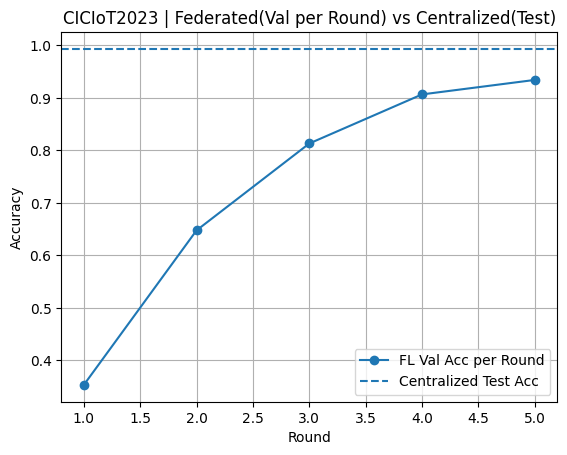

In [12]:
# 중앙집중 리포트
y_pred_c = np.argmax(central.predict(X_test, verbose=0), axis=1)
print("\n[Centralized] Test ACC:", accuracy_score(y_test, y_pred_c))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_c))
print(classification_report(y_test, y_pred_c, target_names=["Normal","Attack"]))

# 연합(베스트-VAL 가중치)
y_pred_fl = np.argmax(global_eval.predict(X_test, verbose=0), axis=1)
print("\n[Federated@Best-VAL] Test ACC:", accuracy_score(y_test, y_pred_fl))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_fl))
print(classification_report(y_test, y_pred_fl, target_names=["Normal","Attack"]))

# 라운드-VAL 정확도 vs 중앙집중 Test 정확도
rs = [r for (r,_) in round_hist]
accs = [a for (_,a) in round_hist]
plt.figure()
plt.plot(rs, accs, marker="o", label="FL Val Acc per Round")
plt.axhline(float(accuracy_score(y_test, y_pred_c)), ls="--", label="Centralized Test Acc")
plt.xlabel("Round"); plt.ylabel("Accuracy")
plt.title("CICIoT2023 | Federated(Val per Round) vs Centralized(Test)")
plt.grid(True); plt.legend(); plt.show()
